# Moving Average Strategies Backtest

This project implements 2 quantitative trading strategies for the S&P 500 ETF (SPY) to demonstrate proficiency in backtesting and machine learning for alpha generation in a hedge fund context. 

The strategies include: 
1) a Single Simple Moving Average (SMA) strategy, generating long signals when the price exceeds the SMA and short otherwise; 
2) a Moving Average Crossover strategy

Leveraging `yfinance`, `pandas`, `matplotlib` and `numpy`, this notebook evaluates performance through cumulative returns, annualized returns, volatility, and Sharpe ratio. The analysis highlights momentum-driven trading, risk management, and portfolio optimization, offering actionable insights for hedge fund applications.

## Strategy 1: Single SMA
We begin with a rule-based strategy that goes long when price is above the SMA and short when price is below.

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
TICKER = 'SPY'


def get_data():
    df = yf.download(TICKER, start='2015-01-01', end='2024-12-31', auto_adjust=False)
    df.columns = df.columns.get_level_values(0)
    return df


def backtest_strategy(df, window):
    df[f'SMA_{window}'] = df['Close'].rolling(window=window, min_periods=1).mean()
    df["Strategy"] = np.where(df["Close"] > df[f'SMA_{window}'], 1, -1)
    df["Strategy"] = df["Strategy"].shift(1)
    
    # Calculate returns
    df["asset_returns"] = df["Close"].pct_change()
    df["strategy_returns"] = df["asset_returns"] * df["Strategy"]
    df["asset_cumulative"] = (1 + df["asset_returns"]).cumprod() - 1
    df["strategy_cumulative"] = (1 + df["strategy_returns"]).cumprod() - 1
    
    return df
    

def calculate_additional_metrics(df, risk_free_rate=0.02):
    # Maximum Drawdown
    df["strategy_peak"] = df["strategy_cumulative"].cummax()
    df["drawdown"] = df["strategy_cumulative"] - df["strategy_peak"]
    max_drawdown = df["drawdown"].min()
    
    # Win Rate and Profit Factor
    df["strategy_profit"] = df["strategy_returns"].apply(lambda x: x if x > 0 else 0)
    df["strategy_loss"] = df["strategy_returns"].apply(lambda x: abs(x) if x < 0 else 0)
    win_rate = len(df[df["strategy_profit"] > 0]) / len(df["strategy_returns"].dropna())
    profit_factor = df["strategy_profit"].sum() / df["strategy_loss"].sum() if df["strategy_loss"].sum() > 0 else float('inf')
    
    # Beta and Correlation (using rolling windows)
    covariance = df["strategy_returns"].rolling(window=252).cov(df["asset_returns"])
    variance = df["asset_returns"].rolling(window=252).var()
    df["beta"] = covariance / variance
    df["correlation"] = df["strategy_returns"].rolling(window=252).corr(df["asset_returns"])
    
    # Turnover Rate (approximate by counting signal changes)
    df["signal_change"] = (df["Strategy"].diff().abs() > 0).astype(int)
    turnover_rate = df["signal_change"].mean()
    
    # Rolling Sharpe Ratio (annualized, 252-day window)
    df["strategy_excess_return"] = df["strategy_returns"] - (risk_free_rate / 252)
    df["rolling_sharpe"] = df["strategy_excess_return"].rolling(window=252).mean() / df["strategy_excess_return"].rolling(window=252).std() * np.sqrt(252)
    
    # Summary statistics
    summary = {
        "Max Drawdown": max_drawdown,
        "Win Rate": win_rate,
        "Profit Factor": profit_factor,
        "Average Beta": df["beta"].mean(),
        "Average Correlation": df["correlation"].mean(),
        "Turnover Rate": turnover_rate,
        "Average Rolling Sharpe": df["rolling_sharpe"].mean()
    }
    return df, summary

In [3]:
df = get_data()
windows = range(10, 201, 10)  # 10 to 200 in steps of 10
results = []

df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-02,171.567993,205.429993,206.880005,204.179993,206.380005,121465900
2015-01-05,168.469528,201.720001,204.369995,201.350006,204.169998,169632600
2015-01-06,166.882767,199.820007,202.720001,198.860001,202.089996,209151400
2015-01-07,168.962280,202.309998,202.720001,200.880005,201.419998,125346700
2015-01-08,171.960556,205.899994,206.160004,203.990005,204.009995,147217800


In [4]:
for window in windows:
    df = backtest_strategy(df, window)
    df, metrics = calculate_additional_metrics(df)
    
    returns = df["strategy_returns"].dropna()
    time_period = (df.index[-1] - df.index[0]).days / 365.25
    annualized_return = returns.mean() * 252
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - 0.02) / volatility if volatility != 0 else 0
    final_cumulative = df["strategy_cumulative"].iloc[-1]
    
    metrics.update({
        'window': window,
        'annualized_return': annualized_return,
        'price_volatility': volatility,
        'sharpe_ratio': sharpe_ratio,
        'final_cumulative': final_cumulative
    })
    results.append(metrics)
    
results_df = pd.DataFrame(results)
results_df.set_index('window', inplace=True)
results_df = results_df.sort_values(by='final_cumulative', ascending=False)
results_df.round(4)

,Max Drawdown,Win Rate,Profit Factor,Average Beta,Average Correlation,Turnover Rate,Average Rolling Sharpe,annualized_return,price_volatility,sharpe_ratio,final_cumulative
window,,,,,,,,,,,
40,-0.3168,0.5199,1.0268,-0.1137,-0.1146,0.0771,0.1182,0.0245,0.1771,0.0253,0.0919
10,-0.6125,0.5004,1.0231,-0.1572,-0.1576,0.1726,-0.0628,0.0211,0.1771,0.0062,0.0557
80,-0.3593,0.5243,1.0138,0.0583,0.0571,0.0457,0.1215,0.0127,0.1771,-0.0413,-0.0296
90,-0.4071,0.5235,1.0083,0.0767,0.0757,0.0465,0.0925,0.0076,0.1771,-0.0699,-0.0775
200,-0.4647,0.5318,1.0036,0.2011,0.2002,0.0338,0.1200,0.0033,0.1771,-0.0944,-0.1166
190,-0.5080,0.5322,1.0014,0.1859,0.1849,0.0354,0.0872,0.0013,0.1771,-0.1056,-0.1339
20,-0.4197,0.5127,0.9999,-0.1709,-0.1716,0.1129,-0.0483,-0.0001,0.1771,-0.1136,-0.1459
30,-0.4333,0.5111,0.9981,-0.1676,-0.1683,0.0922,-0.0963,-0.0018,0.1771,-0.1228,-0.1595
120,-0.4028,0.5239,0.9980,0.1274,0.1264,0.0457,0.0433,-0.0019,0.1771,-0.1234,-0.1607


In [5]:
print(f"\nBest Window by Cumulative Return: {results_df.index[0]} days")
print(f"Metrics for Best Window:\n{results_df.iloc[0].round(4)}")


Best Window by Cumulative Return: 40 days
Metrics for Best Window:
Max Drawdown             -0.3168
Win Rate                  0.5199
Profit Factor             1.0268
Average Beta             -0.1137
Average Correlation      -0.1146
Turnover Rate             0.0771
Average Rolling Sharpe    0.1182
annualized_return         0.0245
price_volatility          0.1771
sharpe_ratio              0.0253
final_cumulative          0.0919
Name: 40, dtype: float64


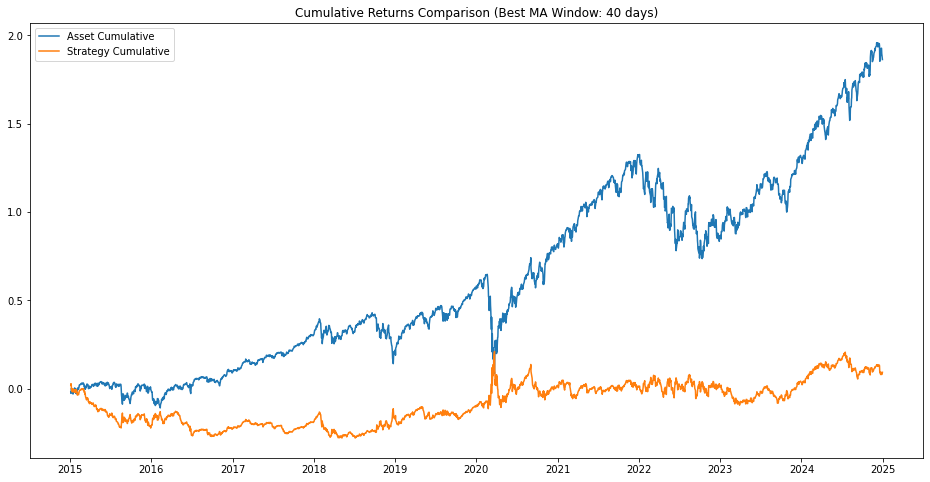

In [6]:
df = backtest_strategy(df, results_df.index[0])
df, _ = calculate_additional_metrics(df)

plt.figure(figsize=(16, 8))
plt.plot(df["asset_cumulative"], label="Asset Cumulative")
plt.plot(df["strategy_cumulative"], label="Strategy Cumulative")
plt.title(f"Cumulative Returns Comparison (Best MA Window: {results_df.index[0]} days)")
plt.legend()
plt.show()

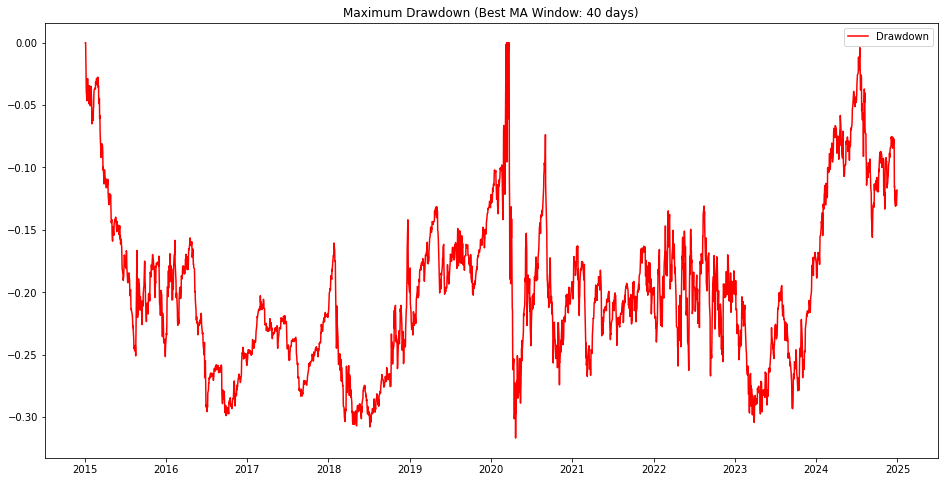

In [7]:
plt.figure(figsize=(16, 8))
plt.plot(df["drawdown"], label="Drawdown", color="red")
plt.title(f"Maximum Drawdown (Best MA Window: {results_df.index[0]} days)")
plt.legend()
plt.show()

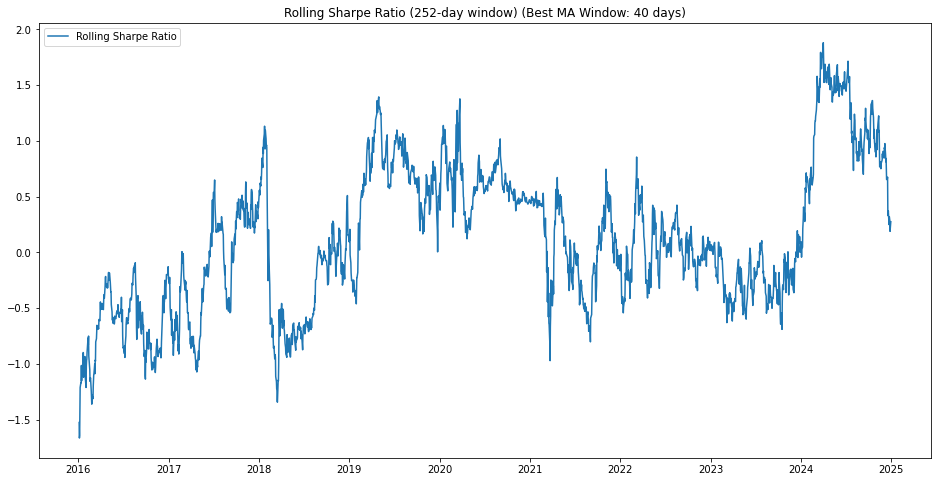

In [8]:
plt.figure(figsize=(16, 8))
plt.plot(df["rolling_sharpe"], label="Rolling Sharpe Ratio")
plt.title(f"Rolling Sharpe Ratio (252-day window) (Best MA Window: {results_df.index[0]} days)")
plt.legend()
plt.show()

### Strategy 1: Results Analysis

The performance metrics for Strategy 1 with the best window of 40 days reveal significant shortcomings, indicating that this is not a good strategy for generating consistent returns. The final cumulative return of 0.0919 (9.19%) over the 2015–2024 period is underwhelming, especially when compared to the asset’s potential buy-and-hold performance, suggesting the strategy struggles to capitalize on market trends. The annualized return of 0.0245 (2.45%) is barely above the assumed 2% risk-free rate, and the Sharpe ratio of 0.0253 reflects poor risk-adjusted returns, barely justifying the volatility of 0.1771. 

Across other windows, the results are equally discouraging. The 10-day window yields a higher final cumulative return (0.0557) but with an alarming Max Drawdown of -0.6125 (-61.25%) and a negative Average Rolling Sharpe (-0.0628), signaling severe risk. Longer windows like 80, 90, and 200 days show even worse final cumulative returns, with declining annualized returns and increasingly negative Sharpe ratios, highlighting a consistent failure to adapt to market conditions.

Given these disappointing outcomes, this single SMA strategy does not appear viable for robust trading performance. Next, we shall try the MA crossover strategy, which combines short and long moving averages to potentially capture trend reversals more effectively and improve overall returns.

## Strategy 2: SMA Average Crossover (2 Moving Averages)

Following the underwhelming results of the Single SMA strategy, it became evident that relying on a single SMA is insufficient for robust trend-following. The Moving Average Crossover strategy addresses these limitations by employing a dual-SMA system to generate signals based on the interaction between short-term and long-term trends. This method aims to improve signal quality, reduce false positives, and enhance risk-adjusted returns, making it a promising next step in our backtesting process.

This rule-based strategy goes long when the shorter moving average is above the longer moving average and vice versa.

In [9]:
TICKER = 'SPY'

def get_data():
    df = yf.download(TICKER, start='2015-01-01', end='2024-12-31', auto_adjust=False)
    df.columns = df.columns.get_level_values(0)
    return df


def backtest_strategy(df, short_window, long_window):
    df[f'SMA_short_{short_window}'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
    df[f'SMA_long_{long_window}'] = df['Close'].rolling(window=long_window, min_periods=1).mean()
    df["Strategy"] = np.where(df[f'SMA_short_{short_window}'] > df[f'SMA_long_{long_window}'], 1, -1)
    df["Strategy"] = df["Strategy"].shift(1)
    
    # Calculate returns
    df["asset_returns"] = df["Close"].pct_change()
    df["strategy_returns"] = df["asset_returns"] * df["Strategy"]
    df["asset_cumulative"] = (1 + df["asset_returns"]).cumprod() - 1
    df["strategy_cumulative"] = (1 + df["strategy_returns"]).cumprod() - 1
    
    return df


def calculate_additional_metrics(df, risk_free_rate=0.02):
    # Maximum Drawdown
    df["strategy_peak"] = df["strategy_cumulative"].cummax()
    df["drawdown"] = df["strategy_cumulative"] - df["strategy_peak"]
    max_drawdown = df["drawdown"].min()
    
    # Win Rate and Profit Factor
    df["strategy_profit"] = df["strategy_returns"].apply(lambda x: x if x > 0 else 0)
    df["strategy_loss"] = df["strategy_returns"].apply(lambda x: abs(x) if x < 0 else 0)
    win_rate = len(df[df["strategy_profit"] > 0]) / len(df["strategy_returns"].dropna())
    profit_factor = df["strategy_profit"].sum() / df["strategy_loss"].sum() if df["strategy_loss"].sum() > 0 else float('inf')
    
    # Beta and Correlation (using rolling windows)
    covariance = df["strategy_returns"].rolling(window=252).cov(df["asset_returns"])
    variance = df["asset_returns"].rolling(window=252).var()
    df["beta"] = covariance / variance
    df["correlation"] = df["strategy_returns"].rolling(window=252).corr(df["asset_returns"])
    
    # Turnover Rate (approximate by counting signal changes)
    df["signal_change"] = (df["Strategy"].diff().abs() > 0).astype(int)
    turnover_rate = df["signal_change"].mean()
    
    # Rolling Sharpe Ratio (annualized, 252-day window)
    df["strategy_excess_return"] = df["strategy_returns"] - (risk_free_rate / 252)
    df["rolling_sharpe"] = df["strategy_excess_return"].rolling(window=252).mean() / df["strategy_excess_return"].rolling(window=252).std() * np.sqrt(252)
    
    # Summary statistics
    summary = {
        "Max Drawdown": max_drawdown,
        "Win Rate": win_rate,
        "Profit Factor": profit_factor,
        "Average Beta": df["beta"].mean(),
        "Average Correlation": df["correlation"].mean(),
        "Turnover Rate": turnover_rate,
        "Average Rolling Sharpe": df["rolling_sharpe"].mean()
    }
    return df, summary


In [10]:
df = get_data()
short_windows = range(10, 101, 10)  # 10 to 100 in steps of 10
long_windows = range(100, 501, 50)  # 100 to 500 in steps of 50
results = []

[*********************100%***********************]  1 of 1 completed


In [11]:
for short in short_windows:
    for long in long_windows:
        if short >= long:
            continue  
        df = df.copy()
        df = backtest_strategy(df, short, long)
        df, metrics = calculate_additional_metrics(df)
        
        returns = df["strategy_returns"].dropna()
        time_period = (df.index[-1] - df.index[0]).days / 365.25
        annualized_return = returns.mean() * 252
        volatility = returns.std() * np.sqrt(252)
        sharpe_ratio = (annualized_return - 0.02) / volatility if volatility != 0 else 0
        final_cumulative = df["strategy_cumulative"].iloc[-1]
        
        # Combine all metrics with window pair
        metrics.update({
            'short_window': short,
            'long_window': long,
            'annualized_return': annualized_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'final_cumulative': final_cumulative
        })
        results.append(metrics)
        
results_df = pd.DataFrame(results)
results_df.set_index(['short_window', 'long_window'], inplace=True)
results_df = results_df.sort_values(by='final_cumulative', ascending=False)
results_df.round(4)

Max Drawdown  Win Rate  Profit Factor  Average Beta  \
short_window long_window                                                        
100          500               -0.5408    0.5386         1.0832        0.5748   
90           500               -0.5669    0.5398         1.0818        0.6035   
10           250               -0.4268    0.5374         1.0809        0.2844   
60           500               -0.6956    0.5430         1.0768        0.5767   
             250               -0.5303    0.5378         1.0746        0.4218   
...                                ...       ...            ...           ...   
40           450               -0.5062    0.5334         0.9970        0.5596   
30           250               -0.6050    0.5358         0.9944        0.4099   
10           500               -0.7117    0.5366         0.9944        0.4725   
50           100               -0.5740    0.5298         0.9891        0.3704   
30           400               -0.5728    0.5334         0.9808        0.4928   

                          Average Correlation  Turnover Rate  \
short_window long_window                                       
100          500                       0.5745         0.0028   
90           500                       0.6031         0.0028   
10           250                       0.2842         0.0091   
60           500                       0.5765         0.0028   
             250                       0.4217         0.0036   
...                                       ...            ...   
40           450                       0.5592         0.0044   
30           250                       0.4097         0.0060   
10           500                       0.4723         0.0083   
50           100                       0.3693         0.0076   
30           400                       0.4928         0.0044   

                          Average Rolling Sharpe  annualized_return  \
short_window long_window                                              
100          500                          0.5001             0.0739   
90           500                          0.4985             0.0728   
10           250                          0.4828             0.0719   
60           500                          0.5017             0.0684   
             250                          0.5032             0.0665   
...                                          ...                ...   
40           450                          0.1476            -0.0028   
30           250                          0.2226            -0.0052   
10           500                          0.1356            -0.0052   
50           100                         -0.0060            -0.0101   
30           400                          0.0531            -0.0179   

                          volatility  sharpe_ratio  final_cumulative  
short_window long_window                                              
100          500              0.1771        0.3045            0.7865  
90           500              0.1771        0.2979            0.7659  
10           250              0.1771        0.2932            0.7519  
60           500              0.1771        0.2736            0.6917  
             250              0.1771        0.2628            0.6598  
...                              ...           ...               ...  
40           450              0.1771       -0.1286           -0.1690  
30           250              0.1771       -0.1421           -0.1891  
10           500              0.1771       -0.1421           -0.1892  
50           100              0.1771       -0.1701           -0.2280  
30           400              0.1771       -0.2142           -0.2859  

[89 rows x 11 columns]

In [12]:
print(f"\nBest Window Combination by Cumulative Return: short={results_df.index[0][0]} days, long={results_df.index[0][1]} days")
print(f"Metrics for Best Window:\n{results_df.iloc[0].round(4)}")


Best Window Combination by Cumulative Return: short=100 days, long=500 days
Metrics for Best Window:
Max Drawdown             -0.5408
Win Rate                  0.5386
Profit Factor             1.0832
Average Beta              0.5748
Average Correlation       0.5745
Turnover Rate             0.0028
Average Rolling Sharpe    0.5001
annualized_return         0.0739
volatility                0.1771
sharpe_ratio              0.3045
final_cumulative          0.7865
Name: (100, 500), dtype: float64


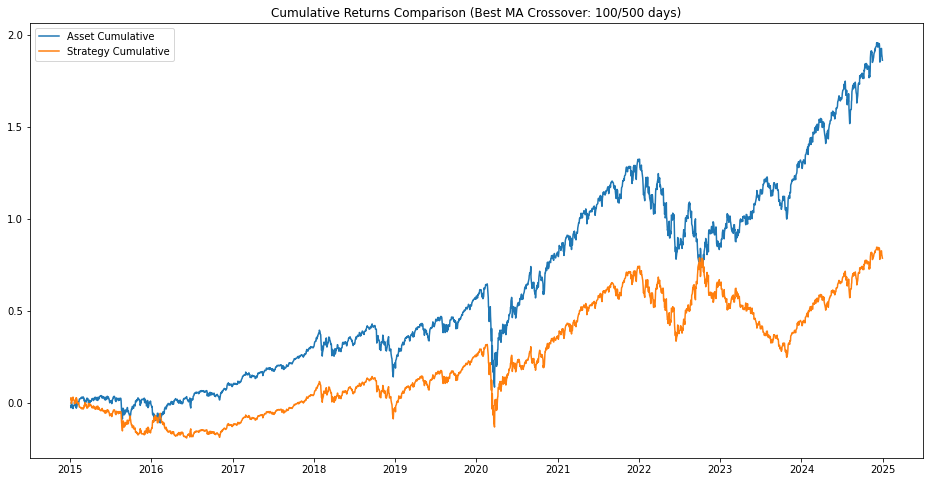

In [13]:
df_best = df.copy()
df_best = backtest_strategy(df_best, results_df.index[0][0], results_df.index[0][1])
df_best, _ = calculate_additional_metrics(df_best)
plt.figure(figsize=(16, 8))
plt.plot(df_best["asset_cumulative"], label="Asset Cumulative")
plt.plot(df_best["strategy_cumulative"], label="Strategy Cumulative")
plt.title(f"Cumulative Returns Comparison (Best MA Crossover: {results_df.index[0][0]}/{results_df.index[0][1]} days)")
plt.legend()
plt.show()

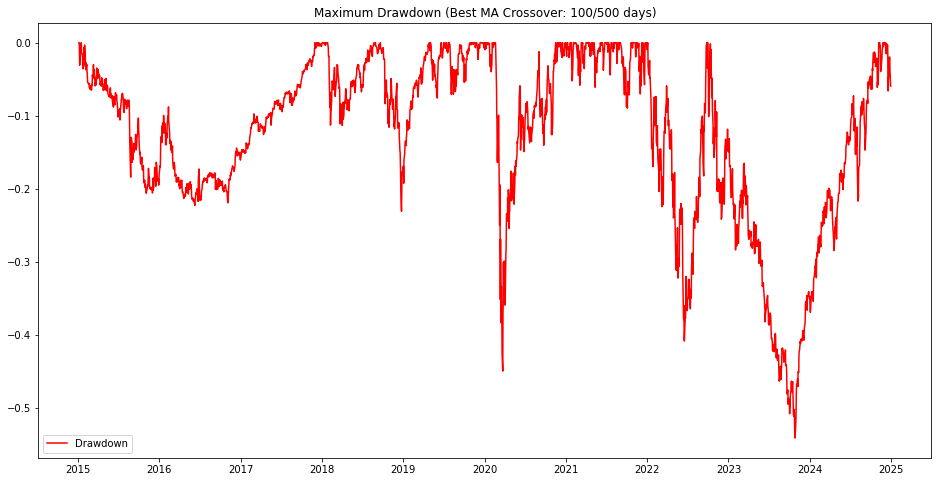

In [14]:
plt.figure(figsize=(16, 8))
plt.plot(df_best["drawdown"], label="Drawdown", color="red")
plt.title(f"Maximum Drawdown (Best MA Crossover: {results_df.index[0][0]}/{results_df.index[0][1]} days)")
plt.legend()
plt.show()

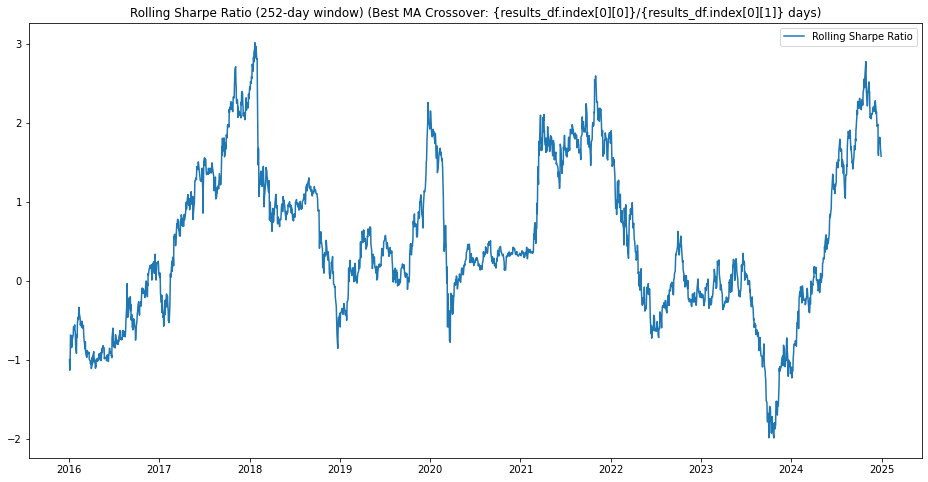

In [15]:
plt.figure(figsize=(16, 8))
plt.plot(df_best["rolling_sharpe"], label="Rolling Sharpe Ratio")
plt.title("Rolling Sharpe Ratio (252-day window) (Best MA Crossover: {results_df.index[0][0]}/{results_df.index[0][1]} days)")
plt.legend()
plt.show()

### Strategy 2: Results Analysis
The performance metrics for the MA crossover Strategy 2, with the best combination of a 100-day short window and a 500-day long window, reveal that this approach is not a good strategy for achieving reliable trading gains. The final cumulative return of 0.7865 (78.65%) over the 2015–2024 period might seem decent at first glance, but it falls significantly short of a simple buy-and-hold strategy for SPY. This underperformance is compounded by a Max Drawdown of -0.5408 (-54.08%), indicating severe losses during downturns that far exceed the buy-and-hold drawdown of approximately -33% during the 2020 COVID crash. The annualized return of 0.0739 (7.39%) lags behind the buy-and-hold annualized return of around 12–15%, and the Sharpe ratio of 0.3045 reflects poor risk-adjusted performance compared to the buy-and-hold Sharpe of roughly 0.6–0.7. The extremely low Turnover Rate of 0.0028 (0.28%) and high Average Beta (0.5748) and Correlation (0.5745) further suggest the strategy is sluggish and overly tied to market movements, lacking agility.

Across other combinations, the results are equally discouraging. The 90/500 and 10/250 pairs offer slightly lower final cumulative returns (0.7659 and 0.7519, respectively) with even worse drawdowns (-0.5669 and -0.4268) than the buy-and-hold peak loss, while longer windows like 60/500 and 40/450 plunge into negative territory (-0.6956 and -0.5062) with annualized returns turning negative, reflecting a consistent inability to adapt. The presence of negative Sharpe ratios (e.g., -0.2142 for 30/400) and final cumulative returns as low as -0.2859 underscores the strategy’s failure across a range of parameters.

Given these disappointing outcomes, this MA crossover strategy also does not hold promise for robust performance.